# New Implementation of scvi using Pyro and Pytorch Lightning

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1t-bIqX3_Nz4qOIjZ8wzNY6QzBt71y4GX?usp=sharing)

This is the re-implementation of the [scVI](https://www.nature.com/articles/s41592-018-0229-2) tool developed by Lopez *et al*. I will use [Pyro](https://pyro.ai/), [PyTorch Lightning](https://www.pytorchlightning.ai/), and Pytorch to re-implement their implementation. Using these libraries has resulted in fewer lines of code, more efficiency, and reliability.

The Lightning and Pyro are not installed in Google Colab by default:

In [ ]:
!pip install pytorch-lightning
!pip install pyro-ppl

In [ ]:
import numpy as np 
import torch 
import torch.nn as nn
import pandas as pd 
from google.colab import drive 

from torch.distributions import kl_divergence as kl
from sklearn.cluster import KMeans
from sklearn import metrics
import seaborn as sn
from matplotlib import pyplot as plt

import pytorch_lightning as pl 
import pyro

Mounting Google Drive so that I can read and write from GDrive.

In [ ]:
drive.mount('/content/gdrive')
base_dir = '/content/gdrive/My Drive/SL_project/'

Mounted at /content/gdrive


I used the [mouse cortex data](https://www.science.org/doi/10.1126/science.aaa1934) published by Zeisel *et al.* to test the performance of the tool and to compare my implementation with the original implementation. Because this data set has cell type labels, it is ideal for testing the Clustering performance of the tool.

In [ ]:
df = pd.read_csv(base_dir + 'Zeisel.zip', compression='zip', delimiter= '\t', low_memory=False)
# Groups of cells, i.e. labels
Groups = df.iloc[0,]
# print(Groups.value_counts())
Groups = Groups.values[2:]

In [ ]:
df1 = df.iloc[10:]
df1.drop(['tissue', 'Unnamed: 0'], inplace=True, axis=1)
df1 = df1.astype(int)
df1.shape

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


(19972, 3005)

In [ ]:
rows = np.count_nonzero(df1, axis=1) > 0 # choosing genes that are transcribed in more than 25 cells
df2 = df1[np.ndarray.tolist(rows)]
# df2 += 1
data = np.ndarray.astype(df2.values, np.float)
# data = np.log10(data)  # log transforming the data
data.shape

(19972, 3005)

In [ ]:
# permutation
# permutation
n_genes = 558 # selecting the number of genes, i.e. number of features

# np.random.seed(197)

Groups = df.iloc[0,] 
Groups = Groups.values[2:]

rows = np.argsort(np.var(data, axis = 1)*-1) # sorting the data based on the variance
df2 = data[rows,:]
df3 = df2[0:n_genes, :] # choosing high variable genes 

p = np.random.permutation(df3.shape[0])
df3[:,:] = df3[p,:]

p = np.random.permutation(df3.shape[1])
df3[:,:] = df3[:,p]

Groups = Groups[p]
df2_tensor = df3.T

expression_train = df2_tensor[0:2253,:]
expression_test = df2_tensor[2253:,:]

expression_train = torch.tensor(expression_train).float()
expression_test = torch.tensor(expression_test).float()

expression = torch.tensor(df2_tensor) #whole data set
expression = expression.float()
# df2_tensor.shape

In [ ]:
def compute_library_size(x, batch = None, batch_num = None):
  # returns library mean and variance which are the batch (single cell batch not deeplearing batch!)variance and mean.

  # for the input without batch number
  if batch is None:
    batch = 1
  if batch_num is None: 
    batch_num = torch.ones([1, x.shape[0]], dtype= int)
  
  y = x[torch.ones([x.shape[0]], dtype= int) == 1]
  
  local_mean = y.mean(1)
  local_var = y.var(1)

  return local_mean, local_var

An NN class that can define fully connected networks with differnt activation functions:

In [ ]:
class NN(nn.Module): 

  def __init__(self, layers, bn, act = 'ReLU', dropout= 0.1, bias = True): 
    
    # use_batch_norm, use_layer_norm, dropout should be added to the model

    super().__init__()

    layer_list = [] 
    len_net = len(layers)
    
    if type(act) is not list:
      act = [act]
      act = act * len_net
    
    if len(act) != len_net:
      act = act*len_net

    for i in range(len_net-1): 

      layer_list.append(nn.Linear(layers[i], layers[i+1], bias = bias))
      
      if bn:
         layer_list.append(
             nn.BatchNorm1d(layers[i+1], momentum=0.01, eps=0.001))
      
      act_str = act[i]
      act_function = getattr(nn, act_str)()
      layer_list.append(act_function)

      if dropout > 0:
        layer_list.append(nn.Dropout(p=dropout))

    self.network = nn.Sequential(*layer_list)

  def forward(self, x):
    return self.network(x)
  

In [ ]:
class encoder(nn.Module):
  
  def __init__(
      self, 
      layers, 
      n_output,
      bn,
      dist = None, # defualt is Normal   
      dropout = 0.1, 
      eps_var = 0.0001): 

    super().__init__()

    self.FC = NN(layers, bn)
    self.en_mean = nn.Linear(layers[-1], n_output)
    self.en_var = nn.Linear(layers[-1], n_output)

    if dist is None: 
      self.dist = torch.distributions.Normal
    else:
      self.dist = getattr(torch.distributions, dist)

    
  def forward(self, x, eps_var = 1e-4):
    latent = self.FC(x)
    latent_m = self.en_mean(latent)
    latent_v = torch.exp(self.en_var(latent)) + eps_var
    
    out = self.dist(latent_m, latent_v.sqrt()).rsample()

    return latent_m, latent_v, out

In [ ]:
class decoder(nn.Module):

  def __init__(
      self, 
      layers,
      n_output, 
      bn,
      act = 'ReLU',
      dropout = 0.1):
    
    super().__init__()

    self.fw = NN(layers, bn, act, dropout)
    self.scale_library = nn.Sequential(nn.Linear(layers[-1], n_output),
                                       nn.Softmax(dim=-1))
    self.dropout_decoder = nn.Linear(layers[-1], n_output)
    self.r_decoder = nn.Sequential(nn.Linear(layers[-1], n_output), nn.ReLU())

  def forward(self, z, library):

    fw = self.fw(z)
    scale = self.scale_library(fw)
    dropout = self.dropout_decoder(fw)
    px_rate = torch.exp(library)* scale
    # rate = scale
    px_r = self.r_decoder(fw)

    return scale, px_r, px_rate, dropout


###The parameters and their meaning


So, I think here the `px_r` is $\theta$ and `px_rate` is $\mu$ in their implementation. 

- `px_r` is the dispersion, the $\theta$, or so called $r$ (the number of failures before success).

In the scvi's original implementation, the Negative Binomial is as following: 

$$
p_{NB}(n,\theta, \mu) = \frac{\Gamma(n+\theta)}{\Gamma(n+1)\Gamma(\theta)}\left(\frac{\theta}{\theta+\mu}\right)^\theta \left(\frac{\mu}{\theta+\mu}\right)^n
$$

However, in the Pyro's implementation, the Negative Binomial is as following: 


$$
p_{NB}(n,r, p) = \frac{\Gamma(n+r)}{\Gamma(n+1)\Gamma(r)}\left(p\right)^n \left(1-p\right)^r
$$

Therefore, the $p$ would be: $$p = \frac{\mu}{\theta+\mu}$$

Consequently, I used Pyro's API as following:

`p = px_r/(px_r + px_rate)`

`zinb = pyro.distributions.ZeroInflatedNegativeBinomial(total_count=px_r, probs=p, gate_logits=px_dropout)`


Now, the problem here is with vaiable `p` constraints which should be in interval $[0,1)$. Some of the values in `p` would be equal to 1. To avoid this issue and for numerical stability, I used the following technique:

I have added an $\epsilon = 10^{-4}$ in the $p$'s equation: 

$$p = \frac{\mu}{\theta+\mu + \epsilon}$$

So in the code: `p = px_r/(px_r + px_rate + 1e-4)`

In [ ]:
class scVI(pl.LightningModule):
  def __init__(self, 
               n_genes, 
               bn_en,  
               bn_de,
               latent_l = 1,
               latent_z = 10): 
    super().__init__()
    layers = [n_genes, 128]
    self.z_encoder = encoder(layers, latent_z, bn_en)
    self.l_encoder = encoder(layers, latent_l, bn_en)

    layers = [latent_z, 128]
    self.decoder = decoder(layers, n_genes, bn_de, dropout=0)

    # params = list(z_encoder.parameters()) + list(l_encoder.parameters()) + list(scVI_decoder.parameters())
  
  def forward(self, x):

      qz_m, qz_v, z = self.z_encoder(x)
      ql_m, ql_v, library = self.l_encoder(x)
      
      px_scale, px_r, px_rate, px_dropout = self.decoder(z, library)
      px_r = torch.exp(px_r)
      
      return qz_m, qz_v, z, ql_m, ql_v, library, px_scale, px_r, px_rate, px_dropout


  def training_step(self, batch, batch_idx):
    (x,) = batch

    qz_m, qz_v, z, ql_m, ql_v, library, px_scale, px_r, px_rate, px_dropout = self(x)
    
    mean = torch.zeros_like(qz_m)
    scale = torch.ones_like(qz_v)

    local_mean, local_var = compute_library_size(x)

    kl_divergence_z = kl(torch.distributions.Normal(qz_m, torch.sqrt(qz_v)),
                        torch.distributions.Normal(mean, scale)).sum(dim=1)

    kl_divergence_l = kl(
          torch.distributions.Normal(ql_m, torch.sqrt(ql_v)),
          torch.distributions.Normal(local_mean, torch.sqrt(local_var)),
      ).sum(dim=1)
    

    p = px_r/(px_r + px_rate + 1e-4)  
    zinb = pyro.distributions.ZeroInflatedNegativeBinomial(total_count=px_r, probs=p, gate_logits=px_dropout)
    r_loss = -zinb.log_prob(x).sum(dim=-1)
    
    
    loss = torch.mean(r_loss + kl_divergence_l + kl_divergence_z)
    self.log('loss', loss.item(), on_epoch = True, on_step = False)

    return loss 

  def configure_optimizers(self):

    return torch.optim.Adam(self.parameters(), lr = 0.001, eps= 0.1)

In [ ]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.trunc_normal_(m.weight.data, 0, 0.01, -0.02, 0.02)

In [ ]:
ds = torch.utils.data.TensorDataset(expression_train)
dl = torch.utils.data.DataLoader(ds, batch_size=128, shuffle=True)

In [ ]:
model = scVI(n_genes, True, True)
model.apply(init_weights)
logger = pl.loggers.CSVLogger("./logs")
trainer = pl.Trainer(max_epochs=50, logger= logger)
trainer.fit(model, dl)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name      | Type    | Params
--------------------------------------
0 | z_encoder | encoder | 74.4 K
1 | l_encoder | encoder | 72.1 K
2 | decoder   | decoder | 217 K 
--------------------------------------
364 K     Trainable params
0         Non-trainable params
364 K     Total params
1.456     Total estimated model params size (MB)
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/data_loading.py:323: UserWarning: The number of training samples (18) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  f"The number of training samples ({self.num_training_batches}) is smaller than the logging interval"


Training: -1it [00:00, ?it/s]

In [ ]:
df = pd.read_csv(f"/content/logs/default/version_{logger.version}/metrics.csv")

In [ ]:
df.head()

,loss,epoch,step
0,3037.415771,0,17
1,2706.208740,1,35
2,2391.257324,2,53
3,2165.448730,3,71
4,2079.818115,4,89


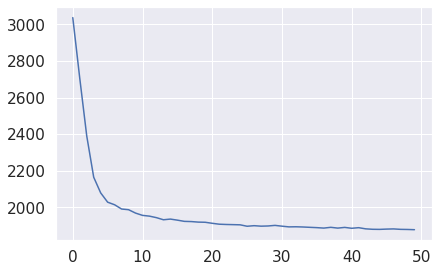

In [ ]:
plt.plot(df.epoch, df.loss)

## Downstream analyses

###Clustering

In [ ]:
with torch.no_grad(): 
  qz_m, qz_v, z, ql_m, ql_v, library, px_scale, px_r, px_rate, px_dropout = model(expression)

In [ ]:
# performing K-means on the encoded data
silhouette_coefficients = []
kmeans_kwargs = {"init": "random", "n_init": 50, "max_iter": 400, "random_state": 197}


for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(z)
    # score = kmeans.inertia_
    score = metrics.silhouette_score(z, kmeans.labels_)
    silhouette_coefficients.append(score)

Since the task is an unsupervised task, we do not know the true number of the clusters. Therefore, one has to choose the optimal number of clusters when using the tool for a new data set without labels. Here, the so called Silhouette plot is used to find the optimum number of clusters. The clustering is performed on the latent variable of the network (the `z`) becuase the network is designed in a way to capture all bilogical variations in `z`. 

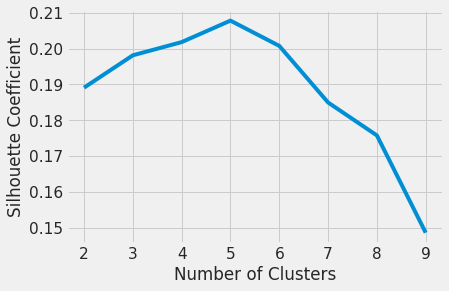

In [ ]:
# Silhouette plot
plt.style.use("fivethirtyeight")
plt.plot(range(2, 10), silhouette_coefficients)
plt.xticks(range(2, 10))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()
# plt.savefig(base_dir + 'test1.png')

The optimum number of clusters is 5 using the Silhouette plot; however, I wanted to compare the results of my implementation with their. Therefore, I have used 6 clusters in the K-means algorithm.

0.6974356463464496


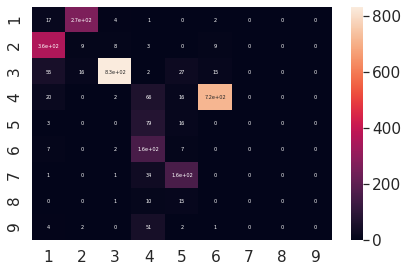

In [ ]:
# Measuring the quality of clustering using NMI and confusion matrix
kmeans = KMeans(n_clusters=6, **kmeans_kwargs)
kmeans.fit(z)

print(metrics.cluster.normalized_mutual_info_score(np.ndarray.astype(Groups, np.int), kmeans.labels_))
CM = metrics.confusion_matrix(np.ndarray.astype(Groups, np.int), kmeans.labels_+1)

df_cm = pd.DataFrame(CM, range(1, CM.shape[0]+1), range(1, CM.shape[1]+1))
# plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 5}) # font size

plt.show()

As one can see, in the last figure, which is the confusion matrix, the true labels and labels resulted from the clustering of the cells are close. Also, the Normalized Mutual Information (NMI) score is near 0.7 which shows the good performance of the clustering. The NMI score resulted from my implementation is almost identical with the one resulted in the original implementation of the scvi.